<img SRC="https://avatars2.githubusercontent.com/u/31697400?s=400&u=a5a6fc31ec93c07853dd53835936fd90c44f7483&v=4" WIDTH=125 ALIGN="right">

# Combining and splitting model layers

*D.A. Brakenhoff, Artesia, 2021*

This notebook shows methods for combining layers and splitting layers for MODFLOW models. Multiple layers can be combined into one layer or one layer can be split into sub-layers based on a fraction of the original thickness.


### Contents<a name="TOC"></a>
1. [Get data](#getdata)
2. [Split layers](#splitlayers)
3. [Combine layers](#combinelayers)

In [1]:
from collections import OrderedDict
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr
from shapely.geometry import LineString
import logging

import nlmod
from art_tools import DatasetCrossSection

In [2]:
print(f'nlmod version: {nlmod.__version__}')

# toon informatie bij het aanroepen van functies
logging.basicConfig(level=logging.INFO)

nlmod version: 0.0.4b


## [1. Get data](#TOC)<a name="getdata"></a>

Define an extent to obtain REGIS

In [3]:
extent = [131000, 136800, 471500, 475700]

Download and cache REGIS netCDF.

In [4]:
ds = nlmod.read.regis.get_regis_dataset(extent, delr=100, delc=100)

INFO:nlmod.read.regis:redefining current extent: [131000, 136800, 471500, 475700], fit to regis raster
INFO:nlmod.read.regis:new extent is [131000, 136800, 471500, 475700] model has 42 rows and 58 columns
INFO:nlmod.mdims.resample:resample regis data to structured modelgrid


Drop all non-existent layers in our area of interest.

In [5]:
nlay, lay_sel = nlmod.read.regis.get_non_nan_layers(ds)
ds = ds.sel(layer=lay_sel)

INFO:nlmod.read.regis:find active layers in raw layer model
INFO:nlmod.read.regis:there are 34 active layers within the extent


Let's take a look at the dataset

In [6]:
ds

<xarray.Dataset>
Dimensions:  (y: 42, x: 58, layer: 34)
Coordinates:
  * y        (y) float64 4.756e+05 4.756e+05 4.754e+05 ... 4.716e+05 4.716e+05
  * x        (x) float64 1.31e+05 1.312e+05 1.312e+05 ... 1.366e+05 1.368e+05
  * layer    (layer) <U64 'HLc' 'BXz2' 'BXz3' 'BXz4' ... 'OOz2' 'OOc' 'BRk1'
Data variables:
    top      (layer, y, x) float64 -1.35 -1.34 -1.37 ... -373.1 -373.0 -372.9
    bot      (layer, y, x) float64 -5.54 -5.53 -5.52 ... -659.3 -659.1 -659.3
    kD       (layer, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    c        (layer, y, x) float64 nan nan nan ... 1.431e+05 1.431e+05 1.432e+05
    kh       (layer, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    kv       (layer, y, x) float64 nan nan nan nan ... 0.002 0.002 0.002 0.002
Attributes:
    extent:    [131000, 136800, 471500, 475700]
    delr:      100
    delc:      100
    gridtype:  structured

Define an line to draw a cross-section

In [7]:
# diagonal line through extent
line = LineString([(extent[0], extent[2]), (extent[1], extent[3])])

Get colors for our cross-section plot.

In [8]:
colors = pd.read_csv("regis_layer_color_codes.csv", index_col=[0])
colors = colors.loc[ds.layer.str.lower()].squeeze().apply(lambda s: eval(s))

Draw the cross-section for REGIS

INFO:shapely.geos:Self-intersection at or near point 3580.5027579936313 -6.4000000953674316
INFO:shapely.geos:Self-intersection at or near point 3580.5027579936313 -8.1800003051757812
INFO:shapely.geos:Self-intersection at or near point 3580.5027579936313 -19.299999237060547
INFO:shapely.geos:Self-intersection at or near point 4815.1588814397164 -17.069999694824219
INFO:shapely.geos:Self-intersection at or near point 740.79367406765141 -18.389999389648438
INFO:shapely.geos:Self-intersection at or near point 3580.5027579936313 -21.420000076293945
INFO:shapely.geos:Self-intersection at or near point 5456.0042026569727 -24.329999923706055
INFO:shapely.geos:Self-intersection at or near point 3580.5027579936313 -48.939998626708984
INFO:shapely.geos:Self-intersection at or near point 3580.5027579936313 -55.090000152587891
INFO:shapely.geos:Self-intersection at or near point 3580.5027579936313 -56.5
INFO:shapely.geos:Self-intersection at or near point 3580.5027579936313 -81.819999694824219
IN

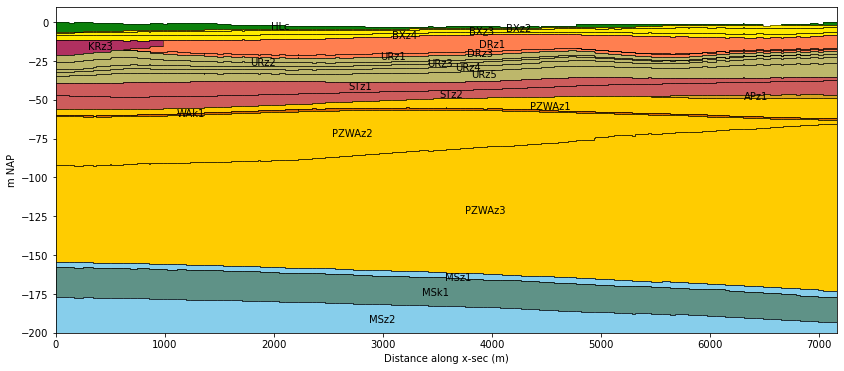

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
dcs = DatasetCrossSection(ds, line=line, top="top", bot="bot", ax=ax, zmin=-200, zmax=10)
dcs.plot_layers(colors=colors, min_label_area=1000)
dcs.plot_grid(linewidth=0.5, vertical=False)
ax.set_ylabel("m NAP")
ax.set_xlabel("Distance along x-sec (m)");

## [2. Split layers](#TOC)<a name="splitlayers"></a>

Define which layers you want to split and determine the indices for those layers

In [10]:
split_layer_codes = ["PZWAz2", "PZWAz3"]
split_lays = np.argwhere(ds.layer.isin(split_layer_codes).data).squeeze()
split_lays

array([19, 20], dtype=int64)

Next determine how to split the layers. This is done by creating a list of fractions that must add up to 1. The layer will be split into sub-layers from the top down, with each sub-layer getting a thickness equal to the fraction times the original thickness.

For example, `(0.5, 0.5)` will split the layer into two sub-layers, each getting a thickness equal to 50% of the original layer.

In [11]:
# split dictionary
split_dict = {
    19: (0.3, 0.3, 0.4),
    20: (0.2, 0.2, 0.2, 0.2, 0.2)
}

Calculate the new layer elevations based on the information above.

In [12]:
ds_split = nlmod.mdims.mlayers.split_layers_ds(ds, split_dict)

INFO:nlmod.mdims.mlayers:Calculating new layer tops and bottoms...
INFO:nlmod.mdims.mlayers:Fill value 'kh' for split layers with value original layer.
INFO:nlmod.mdims.mlayers:Fill value 'kv' for split layers with value original layer.
INFO:nlmod.mdims.mlayers:Done! Created new dataset with split layers!


View the resulting Dataset:

In [13]:
ds_split

<xarray.Dataset>
Dimensions:  (layer: 40, y: 42, x: 58)
Coordinates:
  * layer    (layer) <U8 'HLc' 'BXz2' 'BXz3' 'BXz4' ... 'OOz2' 'OOc' 'BRk1'
  * y        (y) float64 4.756e+05 4.756e+05 4.754e+05 ... 4.716e+05 4.716e+05
  * x        (x) float64 1.31e+05 1.312e+05 1.312e+05 ... 1.366e+05 1.368e+05
Data variables:
    top      (layer, y, x) float64 -1.35 -1.34 -1.37 ... -373.1 -373.0 -372.9
    bot      (layer, y, x) float64 -5.54 -5.53 -5.52 ... -659.3 -659.1 -659.3
    kh       (layer, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    kv       (layer, y, x) float64 nan nan nan nan ... 0.002 0.002 0.002 0.002
Attributes:
    extent:           [131000, 136800, 471500, 475700]
    delr:             100
    delc:             100
    gridtype:         structured
    split_reindexer:  OrderedDict([(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5...

The reindexer dictionary we stored links the new layer numbers to the old
layer numbers. This is convenient for copying data from the original layers to the new sub-layers.

In [14]:
# 1st number = new layer index: should number continuously from 1..N
# 2nd number = old layer index: repeats where layer was split
ds_split.attrs["split_reindexer"]

OrderedDict([(0, 0),
             (1, 1),
             (2, 2),
             (3, 3),
             (4, 4),
             (5, 5),
             (6, 6),
             (7, 7),
             (8, 8),
             (9, 9),
             (10, 10),
             (11, 11),
             (12, 12),
             (13, 13),
             (14, 14),
             (15, 15),
             (16, 16),
             (17, 17),
             (18, 18),
             (19, 19),
             (20, 19),
             (21, 19),
             (22, 20),
             (23, 20),
             (24, 20),
             (25, 20),
             (26, 20),
             (27, 21),
             (28, 22),
             (29, 23),
             (30, 24),
             (31, 25),
             (32, 26),
             (33, 27),
             (34, 28),
             (35, 29),
             (36, 30),
             (37, 31),
             (38, 32),
             (39, 33)])

The new layers are named according to the REGIS codes, with an added number if the layer was split into multiple sub-layers. For plotting a cross-section we want to use the original color from the REGIS cross-section plot for the new sub-layers.

In [15]:
layer_names = []
colors_new = {}
for j, i in ds_split.split_reindexer.items():
    layercode = ds.layer.data[i]
    
    if layercode in layer_names:
        layercode += f"_{np.sum([1 for ilay in layer_names if ilay.startswith(layercode)]) + 1}"
    
    layer_names.append(layercode)
    colors_new[layercode] = colors.iloc[i]

colors_new = pd.Series(colors_new)

Plot the cross-section of the original and the new layer model.

INFO:shapely.geos:Self-intersection at or near point 3580.5027579936313 -6.4000000953674316
INFO:shapely.geos:Self-intersection at or near point 3580.5027579936313 -8.1800003051757812
INFO:shapely.geos:Self-intersection at or near point 3580.5027579936313 -19.299999237060547
INFO:shapely.geos:Self-intersection at or near point 4815.1588814397164 -17.069999694824219
INFO:shapely.geos:Self-intersection at or near point 740.79367406765141 -18.389999389648438
INFO:shapely.geos:Self-intersection at or near point 3580.5027579936313 -21.420000076293945
INFO:shapely.geos:Self-intersection at or near point 5456.0042026569727 -24.329999923706055
INFO:shapely.geos:Self-intersection at or near point 3580.5027579936313 -48.939998626708984
INFO:shapely.geos:Self-intersection at or near point 3580.5027579936313 -55.090000152587891
INFO:shapely.geos:Self-intersection at or near point 3580.5027579936313 -56.5
INFO:shapely.geos:Self-intersection at or near point 3580.5027579936313 -64.207999801635737
IN

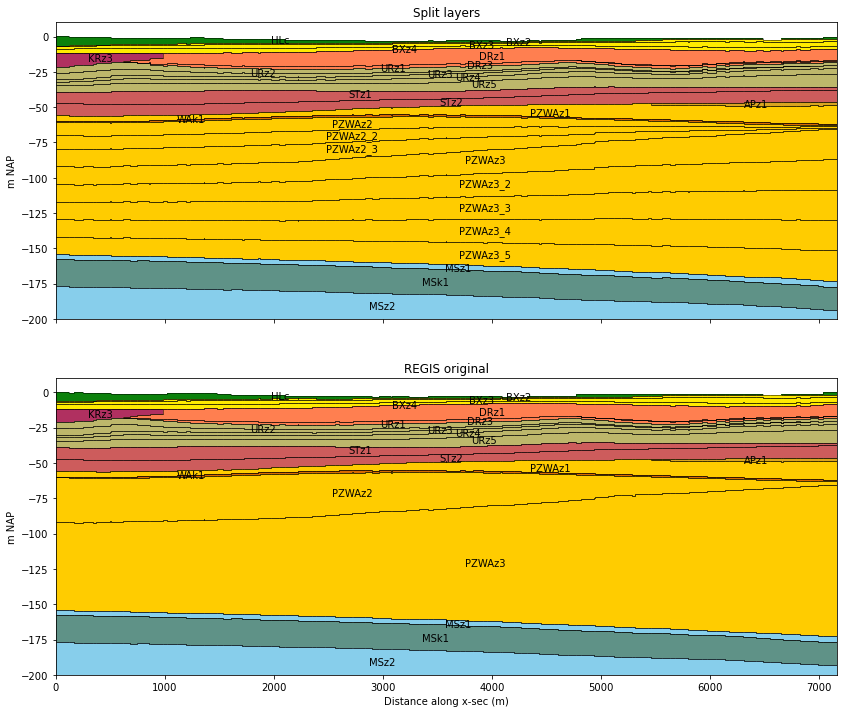

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), sharex=True)
dcs2 = DatasetCrossSection(ds_split, line=line, top="top", bot="bot", ax=ax1, zmin=-200, zmax=10)
polys2 = dcs2.plot_layers(colors=colors_new, min_label_area=1000)
dcs2.plot_grid(linewidth=0.5, vertical=False)
ax1.set_ylabel("m NAP")
ax1.set_title("Split layers")

dcs = DatasetCrossSection(ds, line=line, top="top", bot="bot", ax=ax2, zmin=-200, zmax=10)
polys1 = dcs.plot_layers(colors=colors, min_label_area=1000)
dcs.plot_grid(linewidth=0.5, vertical=False)
ax2.set_ylabel("m NAP")
ax2.set_xlabel("Distance along x-sec (m)")
ax2.set_title("REGIS original");

## [3. Combine layers](#TOC)<a name="combinelayers"></a>

Example how to combine model layers. First find the indices of the layers to combine.

In [17]:
combine_layers = [
    tuple(np.argwhere(ds.layer.str.startswith("URz").data).squeeze().tolist()),
    tuple(np.argwhere(ds.layer.isin(["PZWAz2", "PZWAz3"]).data).squeeze().tolist())
]
combine_layers

[(9, 10, 11, 12, 13), (19, 20)]

Combine layers using the `combine_layers_ds()` function and passing the layer dataset and the list of layer numbers to combine.

In [18]:
ds_combine = nlmod.mdims.mlayers.combine_layers_ds(ds, combine_layers)

INFO:nlmod.mdims.mlayers:Calculating new layer tops and bottoms...
INFO:nlmod.mdims.mlayers:Calculate equivalent 'kh' for combined layers.
INFO:nlmod.mdims.mlayers:Calculate equivalent 'kv' for combined layers.
INFO:nlmod.mdims.mlayers:Calculate value 'kD' for combined layers with sum.
INFO:nlmod.mdims.mlayers:Calculate value 'c' for combined layers with sum.
INFO:nlmod.mdims.mlayers:Done! Created new dataset with combined layers!


Take a look a the resulting dataset

In [19]:
ds_combine

<xarray.Dataset>
Dimensions:  (layer: 29, y: 42, x: 58)
Coordinates:
  * layer    (layer) <U6 'HLc' 'BXz2' 'BXz3' 'BXz4' ... 'OOz2' 'OOc' 'BRk1'
  * y        (y) float64 4.756e+05 4.756e+05 4.754e+05 ... 4.716e+05 4.716e+05
  * x        (x) float64 1.31e+05 1.312e+05 1.312e+05 ... 1.366e+05 1.368e+05
Data variables:
    top      (layer, y, x) float64 -1.35 -1.34 -1.37 ... -373.1 -373.0 -372.9
    bot      (layer, y, x) float64 -5.54 -5.53 -5.52 ... -659.3 -659.1 -659.3
    kh       (layer, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    kv       (layer, y, x) float64 nan nan nan nan ... 0.002 0.002 0.002 0.002
    kD       (layer, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    c        (layer, y, x) float64 nan nan nan ... 1.431e+05 1.431e+05 1.432e+05
Attributes:
    extent:             [131000, 136800, 471500, 475700]
    delr:               100
    delc:               100
    gridtype:           structured
    combine_reindexer:  OrderedDict([(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), ...

Get layer names and colors (use layer code and color from first layer name for the combined layer).

In [20]:
colors_new = {}
for j, i in ds_combine.combine_reindexer.items():
    if isinstance(i, tuple):
        i = i[0]
    layercode = ds.layer.data[i]    
    colors_new[layercode] = colors.iloc[i]

colors_new = pd.Series(colors_new)

Plot the new and the old cross-section.

INFO:shapely.geos:Self-intersection at or near point 3580.5027579936313 -6.4000000953674316
INFO:shapely.geos:Self-intersection at or near point 3580.5027579936313 -8.1800003051757812
INFO:shapely.geos:Self-intersection at or near point 3580.5027579936313 -19.299999237060547
INFO:shapely.geos:Self-intersection at or near point 4815.1588814397164 -17.069999694824219
INFO:shapely.geos:Self-intersection at or near point 740.79367406765141 -18.389999389648438
INFO:shapely.geos:Self-intersection at or near point 3580.5027579936313 -21.420000076293945
INFO:shapely.geos:Self-intersection at or near point 3580.5027579936313 -48.939998626708984
INFO:shapely.geos:Self-intersection at or near point 3580.5027579936313 -55.090000152587891
INFO:shapely.geos:Self-intersection at or near point 3580.5027579936313 -56.5
INFO:shapely.geos:Self-intersection at or near point 3580.5027579936313 -160.83000183105469
INFO:shapely.geos:Self-intersection at or near point 3580.5027579936313 -160.83000183105469
IN

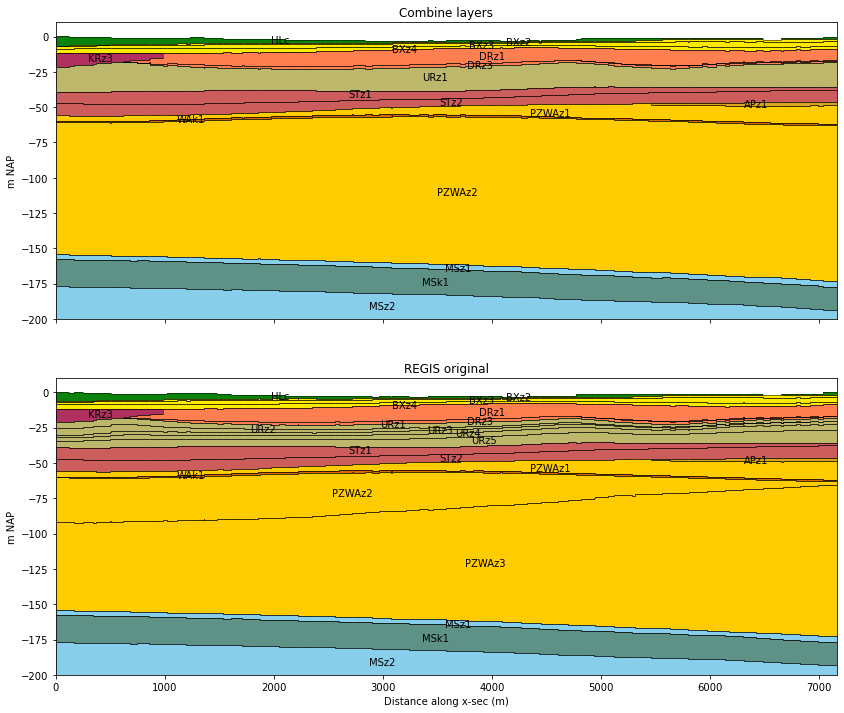

In [21]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), sharex=True)
dcs2 = DatasetCrossSection(ds_combine, line=line, top="top", bot="bot", ax=ax1, zmin=-200, zmax=10)
polys2 = dcs2.plot_layers(colors=colors_new, min_label_area=1000)
dcs2.plot_grid(linewidth=0.5, vertical=False)
ax1.set_ylabel("m NAP")
ax1.set_title("Combine layers")

dcs = DatasetCrossSection(ds, line=line, top="top", bot="bot", ax=ax2, zmin=-200, zmax=10)
polys1 = dcs.plot_layers(colors=colors, min_label_area=1000)
dcs.plot_grid(linewidth=0.5, vertical=False)
ax2.set_ylabel("m NAP")
ax2.set_xlabel("Distance along x-sec (m)")
ax2.set_title("REGIS original");